# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert an SFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.

In [1]:
import pandas as pd
import numpy as np

## Load data 

In [222]:
products = pd.read_csv('amazon_baby_subset.csv')

## Remove punctuation 

In [223]:
import string

In [224]:
products = products.fillna({'review':''})

In [225]:
def remove_punctualtion(text):
    text = text.translate(str.maketrans('','',string.punctuation))
    return text           

In [226]:
products['review_clean'] = products['review'].apply(remove_punctualtion)

Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)

Refer to Module 3 assignment for more details.

In [249]:
important_words = pd.read_json('important_words.json')

In [312]:
word = list(important_words[0].values)

In [256]:
for i in important_words[0]:
    products[i] = products['review_clean'].apply(lambda s : s.split().count(i))

## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=2` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

In [2]:
train_ind = pd.read_json('module-4-assignment-train-idx.json')
valid_ind  = pd.read_json('module-4-assignment-validation-idx.json')

In [259]:
train_data = products.iloc[train_ind[0],:]
valid_data = products.iloc[valid_ind[0],:]

In [260]:
train_data

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Lamaze Peekaboo, I Love You","One of baby's first and favorite books, and it...",4,1,One of babys first and favorite books and it i...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,SoftPlay Peek-A-Boo Where's Elmo A Children's ...,Very cute interactive book! My son loves this ...,5,1,Very cute interactive book My son loves this b...,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
5,Our Baby Girl Memory Book,"Beautiful book, I love it to record cherished ...",5,1,Beautiful book I love it to record cherished t...,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53065,Summer Infant Pop 'n Play Portable Playard,Good idea but too dangerous. I really wanted t...,2,-1,Good idea but too dangerous I really wanted to...,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
53066,Freeens Cool Seat Liner Breathing with 3d Mesh...,It doesn't stay input. My daughter was sliding...,1,-1,It doesnt stay input My daughter was sliding o...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53067,"Samsung Baby Care Washer, Stainless Platinum, ...","My infant goes to a really crappy daycare, and...",1,-1,My infant goes to a really crappy daycare and ...,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
53069,Best BIB for Baby - Soft Bib (Pink-Elephant),Great 5-Star Product but An Obvious knock-off ...,1,-1,Great 5Star Product but An Obvious knockoff of...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [261]:
train_data.shape

(42361, 198)

In [262]:
valid_data.shape

(10711, 198)

In [263]:
def get_numpy_data(dataframe, features, label):
    dataframe['constant'] = 1
    features = ['constant'] + features
    features_frame = dataframe[features]
    feature_matrix = features_frame.to_numpy()
    label_sarray = dataframe[label]
    label_array = label_sarray.to_numpy()
    return(feature_matrix, label_array)

In [264]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, word, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(valid_data, word, 'sentiment') 

<ipython-input-263-9cef56106022>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['constant'] = 1


In [265]:
feature_matrix_train.shape

(42361, 194)

## Building on logistic regression with no L2 penalty assignment

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [266]:
def predict_probability(feature_matrix, coefficients):
    # Take dot product of feature_matrix and coefficients  
    # YOUR CODE HERE
    score = np.dot(feature_matrix,coefficients)
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    # YOUR CODE HERE
    predictions = 1/(1+np.exp(-score))

    # return predictions
    return predictions

# Adding  L2 penalty

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [295]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # Compute the dot product of errors and feature
    ## YOUR CODE HERE
    derivative = np.dot(errors,feature)

    # add L2 penalty term for any feature that isn't the intercept.
    if feature_is_constant == False: 
        ## YOUR CODE HERE
        derivative = derivative - 2*l2_penalty*coefficient
    return derivative

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [296]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    
    return lp

In [297]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        ## YOUR CODE HERE
        predictions = predict_probability(feature_matrix,coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            ## YOUR CODE HERE
            derivative = feature_derivative_with_L2(errors,feature_matrix[:,j],coefficients[j],l2_penalty,is_intercept)
        
            # add the step size times the derivative to the current coefficient
            ## YOUR CODE HERE
            coefficients[j] = coefficients[j] + step_size*derivative
        
        # Checking whether log likelihood is increasing
#         if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
#         or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
#             lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
#             print( 'iteration %*d: log likelihood of observed labels = %.8f' % \
#                 (int(np.ceil(np.log10(max_iter))), itr, lp))
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [298]:
feature_matrix = feature_matrix_train
sentiment = sentiment_train
initial_coefficients = np. zeros(194)
step_size = 5e-6
max_iter = 501

In [299]:
feature_matrix.shape

(42361, 194)

In [300]:
l2_penalty = [0,4,10,1e2,1e3,1e5]

In [301]:
coefficients_penalty = []
for i in l2_penalty:
     coefficients_penalty.append(logistic_regression_with_L2(feature_matrix,sentiment,initial_coefficients,step_size,i,max_iter))

In [313]:
word.insert(0,'intercept')

In [314]:
len(word)

194

In [315]:
table = pd.DataFrame({'word':word})

In [316]:
def add_coefficients_to_table(coefficients, column_name):
    table[column_name] = coefficients
    return table

In [317]:
coefficients_name = ['coefficients_0_penalty','coefficients_4_penalty','coefficients_10_penalty',
                    'coefficients_1e2_penalty','coefficients_1e3_penalty','coefficients_1e5_penalty']

In [318]:
coefficients_dict = dict(zip(coefficients_name,coefficients_penalty))

In [320]:
add_coefficients_to_table(coefficients_dict['coefficients_0_penalty'],'coefficients_0_penalty')
add_coefficients_to_table(coefficients_dict['coefficients_4_penalty'],'coefficients_4_penalty')
add_coefficients_to_table(coefficients_dict['coefficients_10_penalty'],'coefficients_10_penalty')
add_coefficients_to_table(coefficients_dict['coefficients_1e2_penalty'],'coefficients_1e2_penalty')
add_coefficients_to_table(coefficients_dict['coefficients_1e3_penalty'],'coefficients_1e3_penalty')
add_coefficients_to_table(coefficients_dict['coefficients_1e5_penalty'],'coefficients_1e5_penalty')

,word,coefficients_0_penalty,coefficients_4_penalty,coefficients_10_penalty,coefficients_1e2_penalty,coefficients_1e3_penalty,coefficients_1e5_penalty
0,intercept,-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
...,...,...,...,...,...,...,...
189,babies,0.052494,0.052130,0.051594,0.044805,0.021026,0.000365
190,won,0.004960,0.004907,0.004830,0.003848,0.001084,0.000017
191,tub,-0.166745,-0.165367,-0.163338,-0.137693,-0.054778,-0.000936
192,almost,-0.031916,-0.031621,-0.031186,-0.025604,-0.007361,-0.000125


In [321]:
table.head()

,word,coefficients_0_penalty,coefficients_4_penalty,coefficients_10_penalty,coefficients_1e2_penalty,coefficients_1e3_penalty,coefficients_1e5_penalty
0,intercept,-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042


In [322]:
positive_words = table.sort_values('coefficients_0_penalty',ascending=False)['word'][0:5].tolist()
positive_words

['love', 'loves', 'easy', 'perfect', 'great']

In [323]:
negative_words = table.sort_values('coefficients_0_penalty',ascending=True)['word'][0:5].tolist()
negative_words

['disappointed', 'money', 'return', 'waste', 'returned']

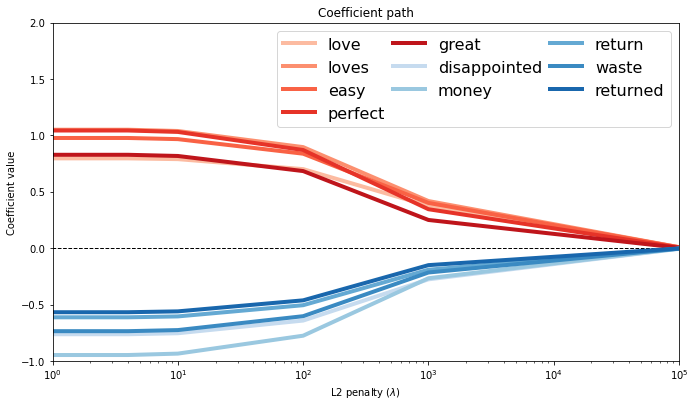

In [324]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = table[table['word'].isin(positive_words)]
    table_negative_words = table[table['word'].isin(negative_words)]
    del table_positive_words['word']
    del table_negative_words['word']
    
    for i in range(len(positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].to_numpy().flatten(),
                 '-', label=positive_words[i], linewidth=4.0, color=color)
        
    for i in range(len(negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].to_numpy().flatten(),
                 '-', label=negative_words[i], linewidth=4.0, color=color)
        
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()


make_coefficient_plot(table, positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [325]:
def compute_accuracy(feature_matrix,sentiment,coefficient):
    score = np.dot(feature_matrix,coefficient)
    predictions = np.array([1 if x > 0 else -1 for x in score])
    accuracy = sum(predictions==sentiment)/len(sentiment)
    return accuracy

In [338]:
train_accuracy = {}
train_accuracy[0]   = compute_accuracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_0_penalty'])
train_accuracy[4]   = compute_accuracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_4_penalty'])
train_accuracy[10]  = compute_accuracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_10_penalty'])
train_accuracy[1e2] = compute_accuracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_1e2_penalty'])
train_accuracy[1e3] = compute_accuracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_1e3_penalty'])
train_accuracy[1e5] = compute_accuracy(feature_matrix_train, sentiment_train, coefficients_dict['coefficients_1e5_penalty'])

validation_accuracy = {}
validation_accuracy[0]   = compute_accuracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_0_penalty'])
validation_accuracy[4]   = compute_accuracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_4_penalty'])
validation_accuracy[10]  = compute_accuracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_10_penalty'])
validation_accuracy[1e2] = compute_accuracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_1e2_penalty'])
validation_accuracy[1e3] = compute_accuracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_1e3_penalty'])
validation_accuracy[1e5] = compute_accuracy(feature_matrix_valid, sentiment_valid, coefficients_dict['coefficients_1e5_penalty'])

In [340]:
for key in sorted(validation_accuracy.keys()):
    print( "L2 penalty = %g" % key)
    print( "train accuracy = %s, validation_accuracy = %s" % (train_accuracy[key], validation_accuracy[key]))
    print( "--------------------------------------------------------------------------------")


L2 penalty = 0
train accuracy = 0.7851561577866434, validation_accuracy = 0.781439641490057
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.7851089445480512, validation_accuracy = 0.7815330034543927
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.7849909114515711, validation_accuracy = 0.7817197273830642
--------------------------------------------------------------------------------
L2 penalty = 100
train accuracy = 0.7839758268218409, validation_accuracy = 0.781066193632714
--------------------------------------------------------------------------------
L2 penalty = 1000
train accuracy = 0.7758551497839994, validation_accuracy = 0.7713565493417982
--------------------------------------------------------------------------------
L2 penalty = 100000
train accuracy = 0.6803663747314747, validation_accuracy = 0.667818130893474
-----------------------------